In [1]:
from odds import OD
from test_data import generate_test
import datetime
from time import time
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from utils import auc, fps, TimeoutException
import os
import numpy as np
import stopit
import pandas as pd

In [2]:
n = 100
p = 32

gamma = 0.05
p_frac = 0.3
p_quant = 0.3
r = 20
# out_type = 'point'
os.makedirs("./images/", exist_ok=True)


In [58]:

def contour_fp_np(n_lst, p_lst, r, noise, ta, p_quant, p_frac, n_runs, gamma,algo,algo_str, metric, timeout, timestamp):
    """
    gets data for contour plot varying
    n - number of samples
    p - number of features
    with 0.3 p frac and p_quant, using ceiling, so always at least 1 outlier
    saving the data in a text file with the time stamp given.
    """

    all_name = './results/{}_np_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, '.format('algo', 'ta', 'score', 'n', 'p')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for p_pow in p_lst:
        fp_row=[]
        auc_row=[]
        succeed = True
        for n_pow in n_lst:
            Fail = False
            t0 = time()
            fp_runs=[]
            auc_runs=[]
            n = 10**n_pow
            p = 2**p_pow

            for i in range(n_runs):

                la_err = True
                while la_err and succeed:
                    try:
                        X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                        with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                            fp, auc = test_algo(X, outs, algo, metric)
                        if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                            raise TimeoutException(timeout)
                        la_err = False

                    except np.linalg.LinAlgError as err:
                        if 'Singular matrix' in str(err):
                            la_err = True
                            print('redoing due to singular matrix err')
                        elif 'SVD did not converge' in str(err):
                            la_err = True
                            print('redoing due to SVD not converging')
                        else:
                            print('some other linalg error')
                            raise(err)
                    except TimeoutException as err:
                        succeed = False
                        #want it not to bother to run another run,
                        #and not to bother trying the next n_pow up
                if succeed:
                    fp_runs.append(fp)
                    auc_runs.append(auc)
                else:
                    break
            t1 = time() - t0
            if Fail:
                Fail = False
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                print('n={}, p={}, Failed, LinAlgError'.format(n, p))
            elif not succeed:
                print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                    auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                    f.write(fp_str)
                    f.write(auc_str)
            else:
                fp_row.append(np.mean(fp_runs))
                auc_row.append(np.mean(auc_runs))
                #saving raw data to file
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'fps',n,p)
                    fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                    auc_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'auc',n,p)
                    auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
                print('n={}, p={}, runs={}, time= {}m {}s'.format(n, p, n_runs, int(t1//60),int(t1%60)))
        fps.append(fp_row)
        aucs.append(auc_row)

    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz

def plot_each_algo_for_np(n_lst, p_lst, r, gamma, noise, ta, p_quant, p_frac, n_runs,
                            algo_lst, metric, timeout, timestamp):



    t0 = time()

    for i in range(len(algo_lst)):
        algo = algo_lst[i]
        t1 = time()
        od = OD(algo)

        print('{}'.format(algo))
        fpz, aucz = contour_fp_np(n_lst, p_lst, r, noise, ta,p_quant, p_frac, n_runs, gamma,od.get_os, algo, metric, timeout, timestamp)

        t2 = time()-t1

        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(n_lst)*len(p_lst)*n_runs))
    t3 = time()-t0

    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))
    return

def test_algo(X, outs, algo, metric):
    """
    takes in algorithm 'algo', data 'X', with outlier indices 'outs'
    returns fps and auc score, defined in the list of metrics 'metric'
    algo must have input only X
    """
    outlier_scores = algo(X)
    fps = metric[1](outlier_scores, outs)
    aucs = metric[0](outlier_scores, outs)

    return fps, aucs


def get_contour_plot(path, ts,ta, score, atd=None):
    """
    reads the file to get the plot_type, the number of runs and other data
    Here's one I prepared earlier..
    """
    for file in os.listdir(path):
        if ts in file and 'all' in file:
            plot_type = file[20:22]
            print(file,plot_type)


    if atd == None:
        algo_type_dict={'reg':['VAR', 'FRO', 'FRL', 'FRR'], 'dens':['OCSVM', 'GMM', 'DBSCAN', 'IF'],
                        'dl':['AE', 'VAE', 'LSTM', 'GRU'], 'mat':['OP', 'GOP']}
    else:
        algo_type_dict=atd
    

    if plot_type == 'np':
        nv = 24
        rx = 6
        ry = 4
        xl = 'samples'
        yl = 'features'

    elif plot_type == 'pf':
        nv = 36
        rx = 6
        ry = 6
        xl = 'p_frac'
        yl = 'p_quant'

    else:
        raise 'unknown plot type error'
    
    
    # get df from results
    if plot_type == 'np':
        df, dfr = get_all_data_np(timestamp)
    elif plot_type == 'pf':
        df, dfr = get_all_data_pfq(timestamp)
        
    df = df[df['ta']==str(ta)] # select data from appropriate dataset

    df=df[df['score']==score] # select appropriate scores

    w = len(algo_type_dict[algo_type])
    v=1
    fig_size_x = w*5
    fig_size_y = 5
    plt.figure(figsize=(fig_size_x, fig_size_y))
    for i in range(w):
        algo = algo_type_dict[algo_type][i]
        dfa = df[df['algo'] ==algo]

        plt.subplot(v,w, (w*0 + i)+1)
        if i == 0:
            plt.ylabel(yl)
        label = 'ta_{}'.format(ta)
        plt.title('{}'.format(algo))

        if plot_type == 'pf':
            pqs = dfa['pq'].to_numpy().reshape(rx, ry)
            pfs = dfa['pf'].to_numpy().reshape(rx, ry)
            pqs = pqs.astype(float)
            pfs = pfs.astype(float)
            avgs = dfa['mean'].to_numpy().reshape(rx, ry)
            plt.contourf(pqs, pfs, avgs,np.arange(0,1+1e-8,0.05),vmin=0, vmax=1) #

        elif plot_type == 'np':
            ns = dfa['n'].to_numpy().reshape(rx, ry)
            ps = dfa['p'].to_numpy().reshape(rx, ry)
            ns = ns.astype(int)
            ps = ps.astype(int)
            avgs = dfa['mean'].to_numpy().reshape(rx, ry)

            plt.xscale('log')
            plt.yscale('log')

            plt.contourf(ns, ps, avgs,levels=np.arange(0,1+1e-8,0.05),vmin=0, vmax=1)

        else:
            raise 'plot type unknown'
        plt.xlabel(xl)
        if i == w-1:
            plt.colorbar()
    fname = './images/{}_{}_{}_ta{}.eps'.format(ts, plot_type, algo_type, ta)

    plt.savefig(fname, bbox_inches='tight', pad_inches=0)
    plt.show()
    plt.close()
    
def get_all_data_np(timestamp):
    all_name = './results/{}_np_all.txt'.format(timestamp)

    df = pd.read_csv(all_name, skipinitialspace=True, index_col=False, header=0)
    n_runs = int(df.columns[-1])
    df['ta']=df.ta.astype('str')
    df['n']=df.n.astype('str')
    df['p']=df.p.astype('str')


    dfm = df.mean(axis=1, skipna=True, numeric_only=True)

    df['mean']=dfm

    dfr=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1 )
    dfr = dfr.pivot_table(index='algo', columns=['score', 'ta'],values=['mean'])
    dfr = dfr.round(2)
    dfr = dfr.astype(type('s'))
#     print(dfr)
    return df, dfr

def get_all_data_pfq(timestamp):
    all_name = './results/{}_pfq_all.txt'.format(timestamp)

    df = pd.read_csv(all_name, skipinitialspace=True, index_col=False, header=0)
    n_runs = int(df.columns[-1])
    df['ta']=df.ta.astype('str')
    df['pf']=df.pf.astype('str')
    df['pq']=df.pq.astype('str')


    dfm = df.mean(axis=1, skipna=True, numeric_only=True)

    df['mean']=dfm

    dfr=df.drop([str(x) for x in (np.arange(n_runs)+1)], axis=1 )
    dfr = dfr.pivot_table(index='algo', columns=['score', 'ta'],values=['mean'])
    dfr = dfr.round(2)
    dfr = dfr.astype(type('s'))
#     print(dfr)
    return df, dfr

def run_np_experiment_1(timestamp, ta_lst, p_lst, n_lst):

    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']

    r = 20
    p_frac = 0.3
    p_quant = 0.3
    n_runs = 10
    gamma = 0.05
    timeout = 120
    noise=.1


    ## for testing - comment out to run full experiment. may take a while..
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR']
    n_runs=2
    ## end of testing section

    metric_lst = [auc, fps]
    for ta in ta_lst:
        plot_each_algo_for_np(n_lst, p_lst, r, gamma, noise, ta, p_quant, p_frac,n_runs,
                                    algo_lst, metric_lst, timeout, timestamp)
    df, dfr = get_all_data_np(timestamp)
    for ta in ta_lst:
        for metric in metric_lst:
            print(metric, ta)
            get_contour_plot(timestamp,ta, len(p_lst), len(n_lst), 'np', 
                             algo_type, metric, df, n_runs)

    return



To pull results from an old experiment out and plot it:

2021-04-26_10-01-46
Algorithm type = reg, Dataset = 1
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


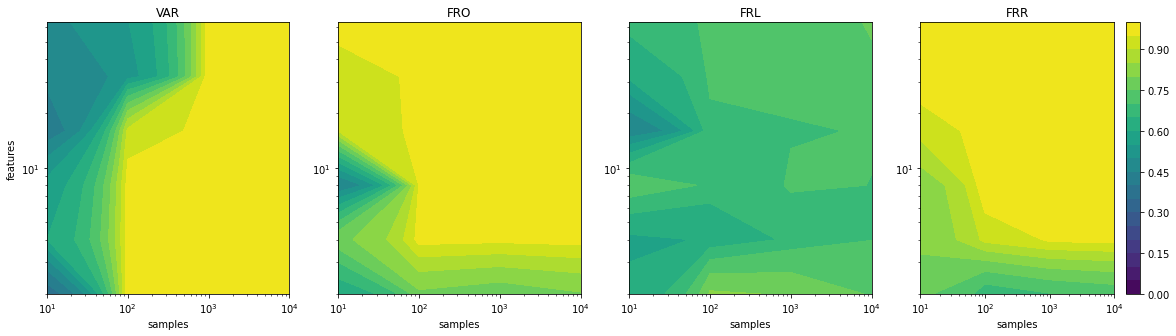

Algorithm type = dens, Dataset = 1
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


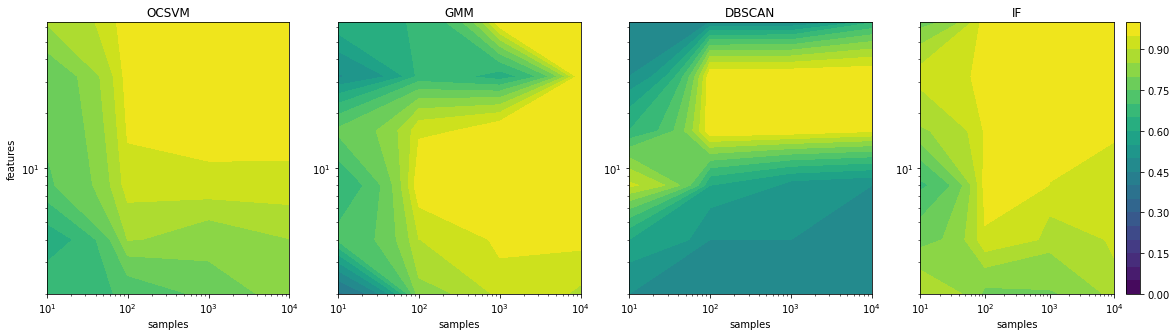

Algorithm type = dl, Dataset = 1
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


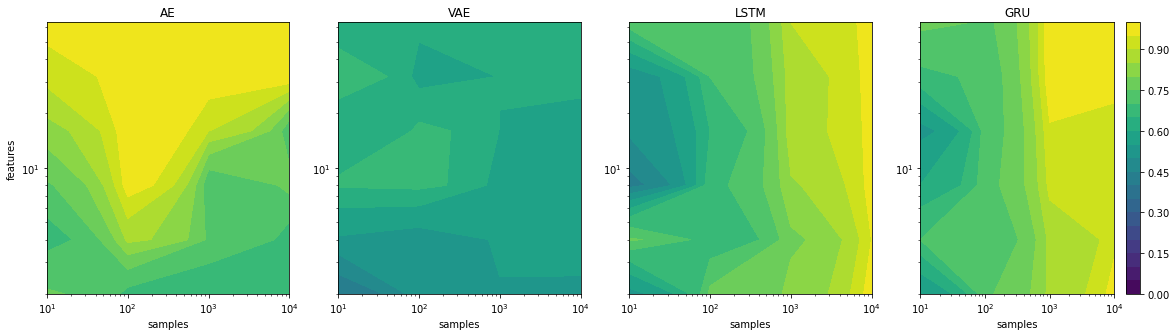

Algorithm type = mat, Dataset = 1
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


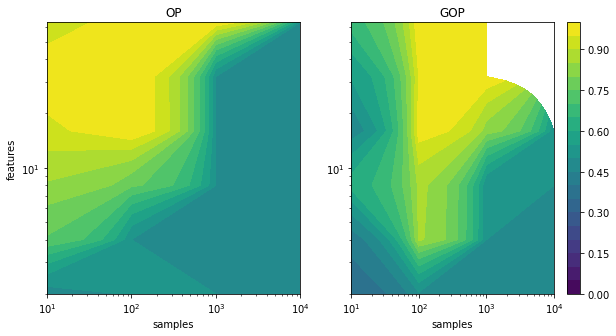

Algorithm type = reg, Dataset = 2
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


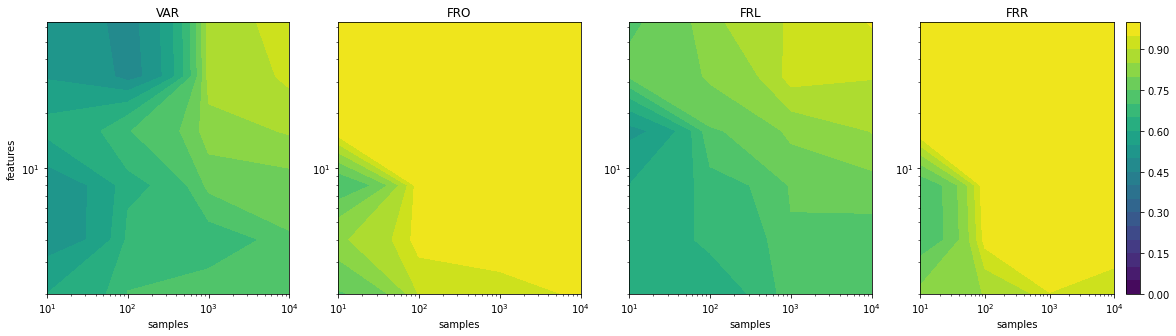

Algorithm type = dens, Dataset = 2
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


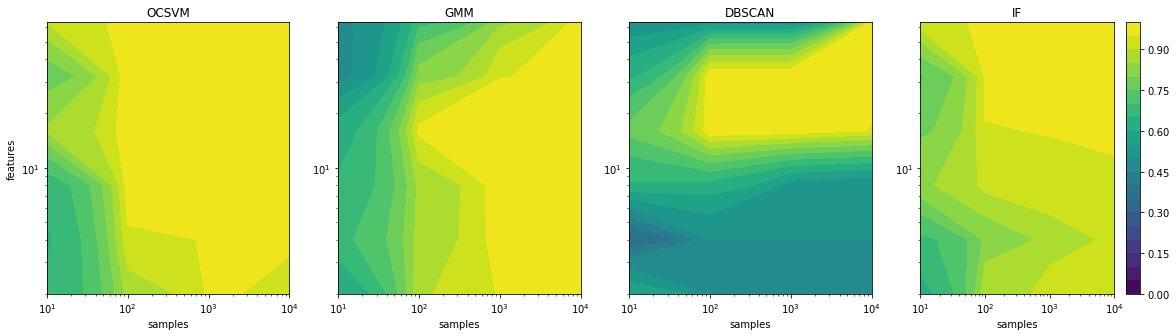

Algorithm type = dl, Dataset = 2
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


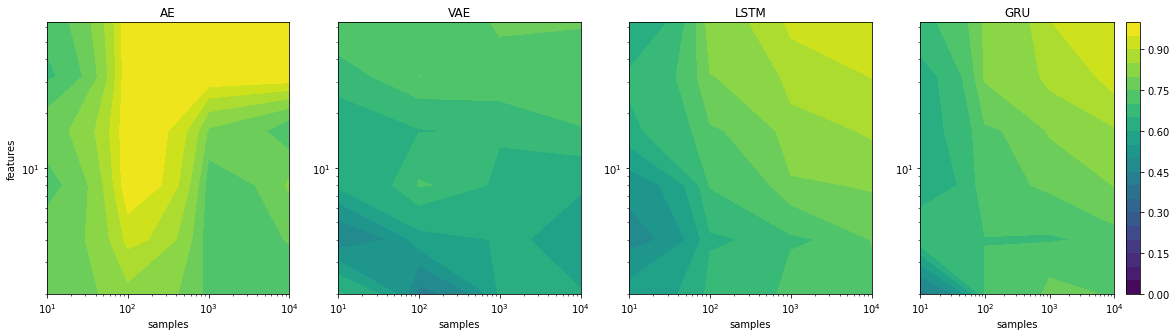

Algorithm type = mat, Dataset = 2
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


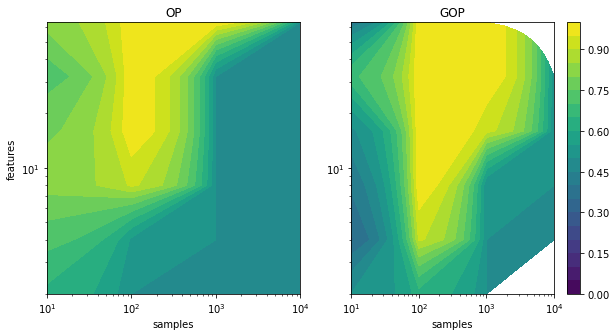

Algorithm type = reg, Dataset = 3
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


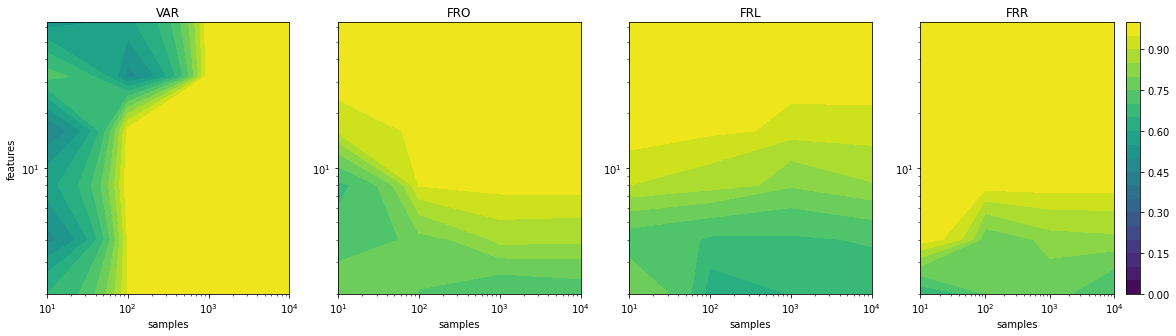

Algorithm type = dens, Dataset = 3
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


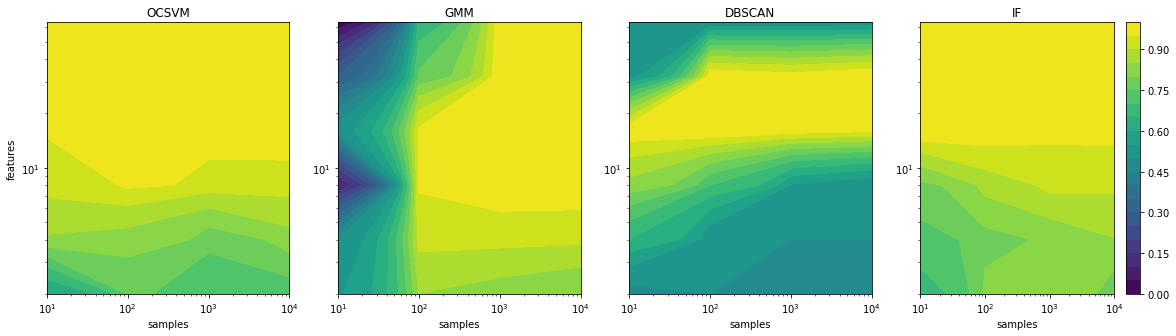

Algorithm type = dl, Dataset = 3
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


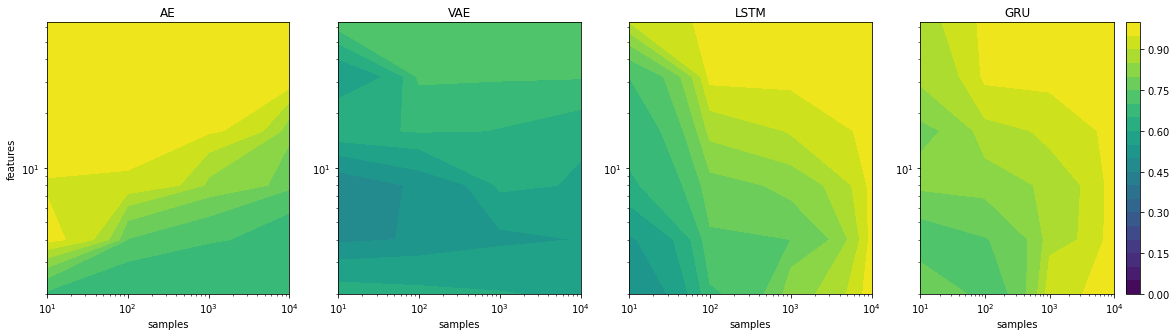

Algorithm type = mat, Dataset = 3
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


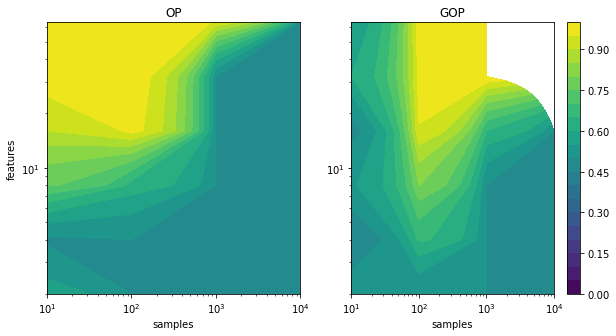

Algorithm type = reg, Dataset = 4
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


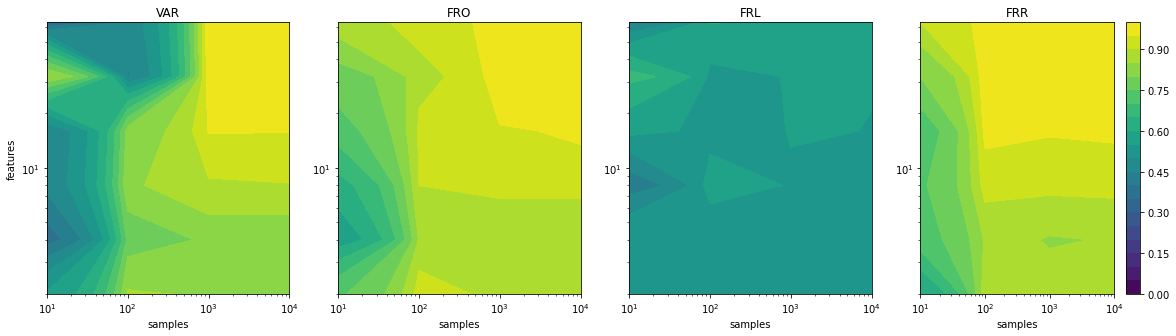

Algorithm type = dens, Dataset = 4
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


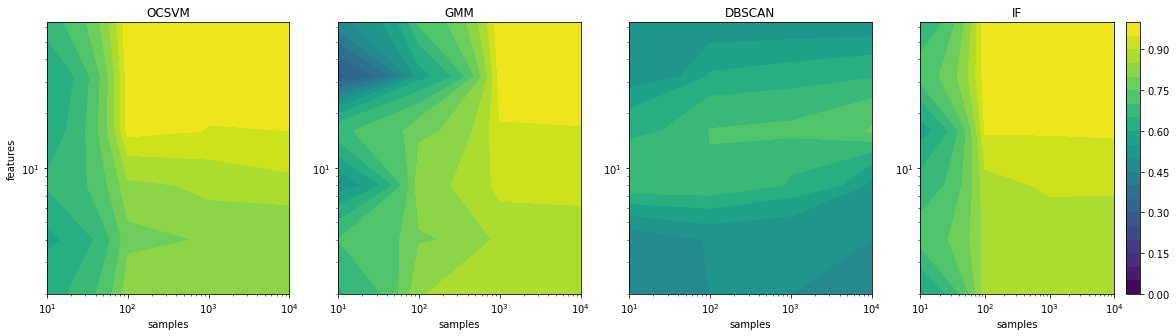

Algorithm type = dl, Dataset = 4
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


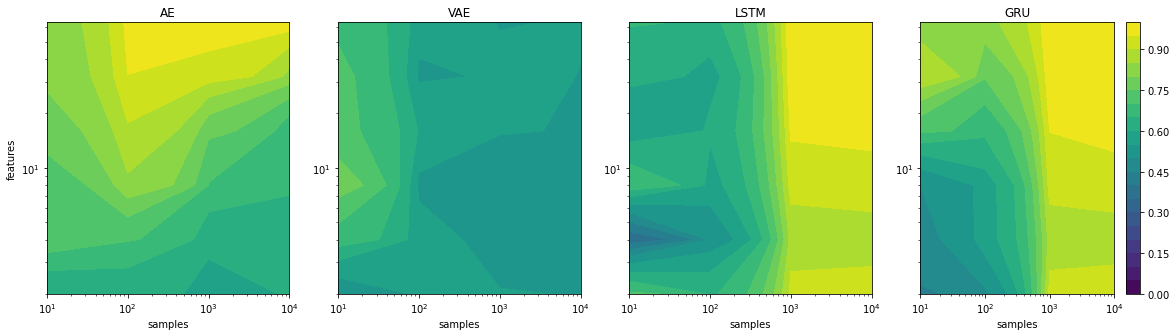

Algorithm type = mat, Dataset = 4
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


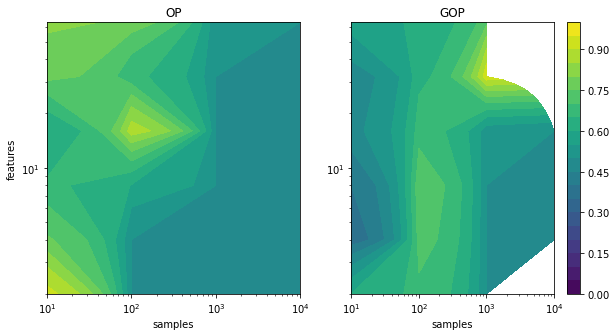

Algorithm type = reg, Dataset = 5
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


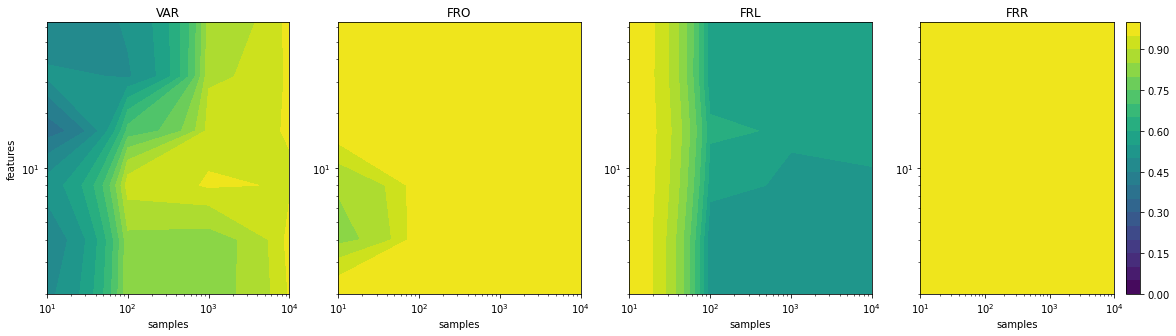

Algorithm type = dens, Dataset = 5
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


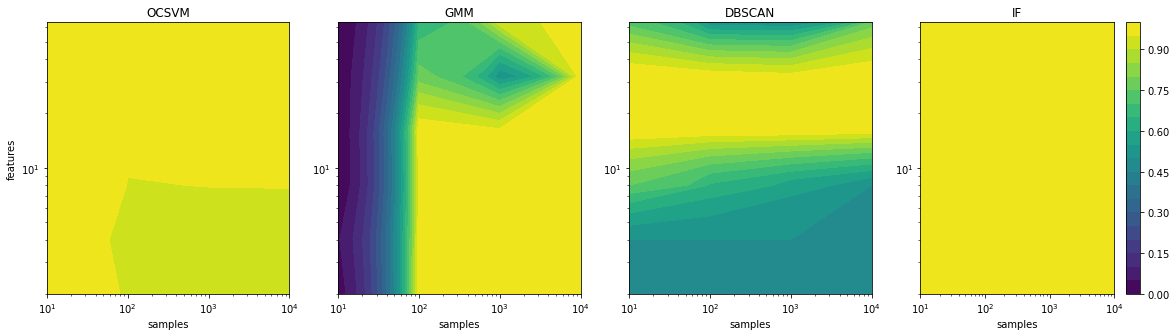

Algorithm type = dl, Dataset = 5
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


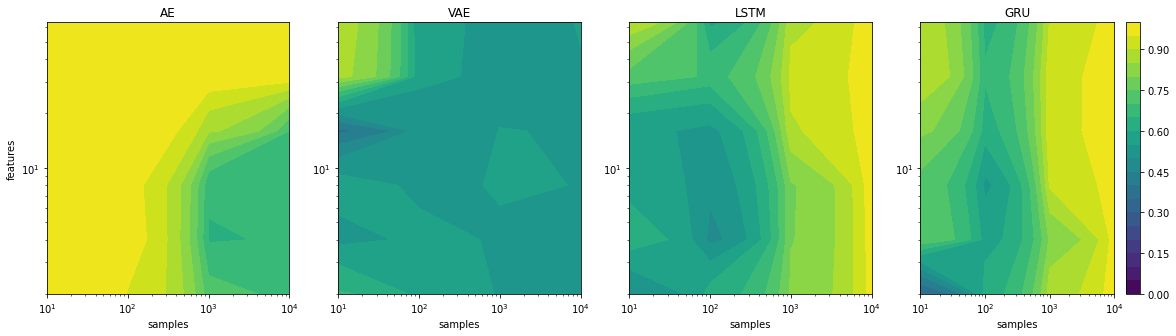

Algorithm type = mat, Dataset = 5
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


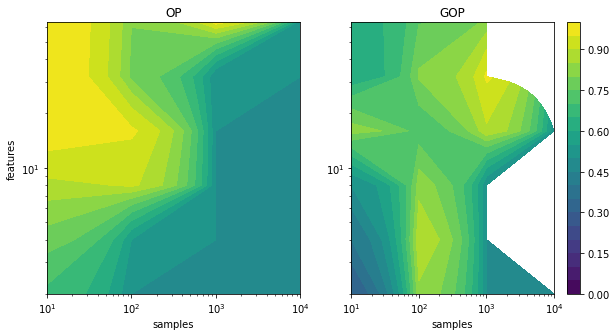

Algorithm type = reg, Dataset = 6
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


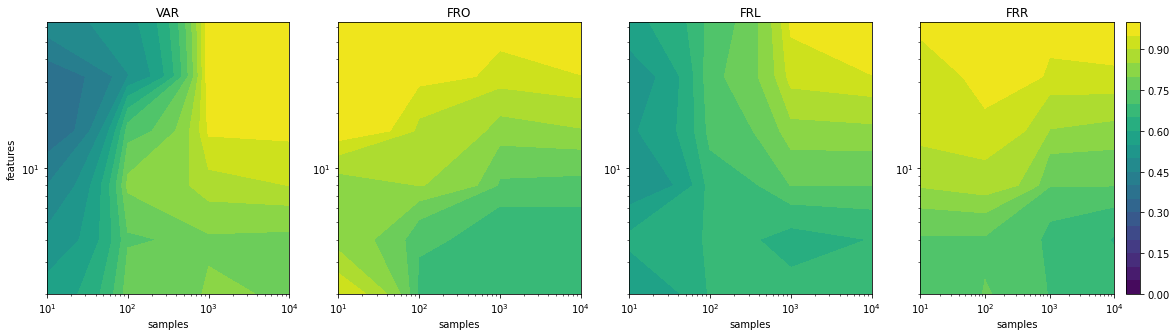

Algorithm type = dens, Dataset = 6
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


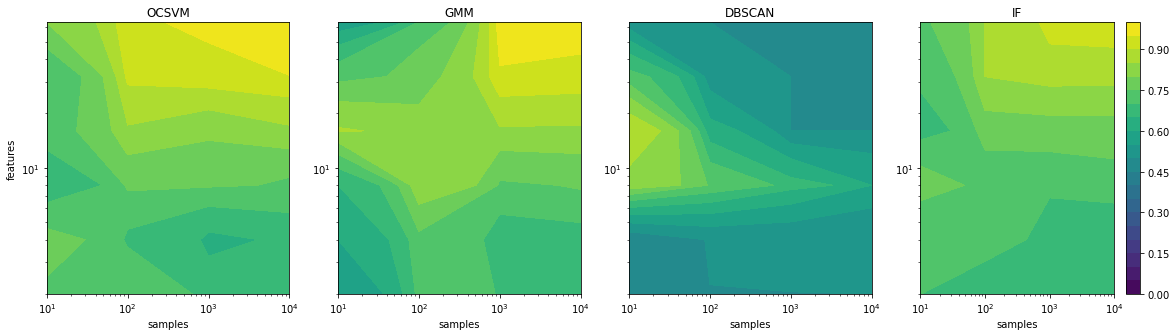

Algorithm type = dl, Dataset = 6
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


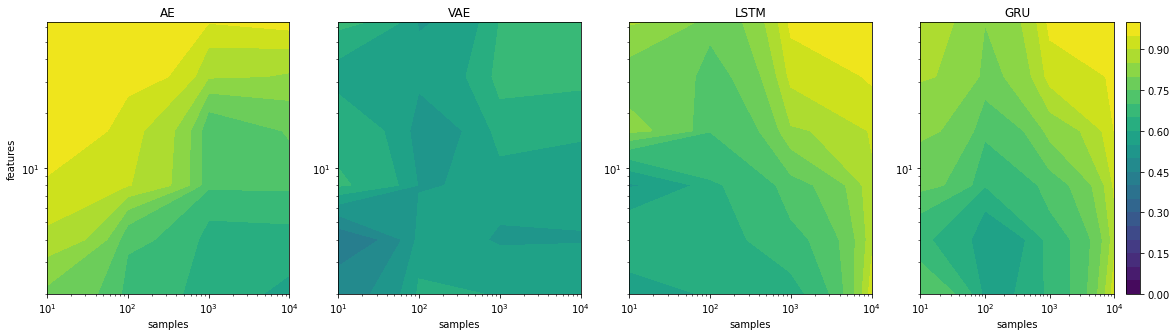

Algorithm type = mat, Dataset = 6
2021-04-26_10-01-46_np_all.txt np
2021-04-26_10-01-46_np_all 2.txt np


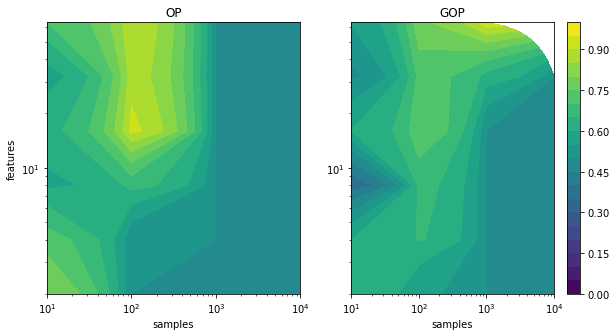

In [56]:
timestamp = '2021-11-26_10-04-07' # edit this line to chose a different set of results
timestamp = '2021-04-26_10-01-46'

print(timestamp)
# print(dfr)
path = './results/'
ta=1
n_runs=10
score='auc'
for dataset in [1,2,3,4,5,6]:
    for algo_type in ['reg', 'dens', 'dl', 'mat']:  ## comment the rest of this back in for full experiment
        print(f'Algorithm type = {algo_type}, Dataset = {dataset}')
        get_contour_plot(path, timestamp,dataset, score)

To run experiment 1 again, run the box below. This may take quite a while.

In [ ]:
ta_lst = [1, 2, 3, 4, 5, 6]
p_lst = [1, 2, 3, 4, 5, 6] # for each level of feature size 2,4,8,16,32,64
n_lst = [1, 2, 3, 4] # for each level of population size 10,100,1000,10000
timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)
#runs experiment 1 with the timestamp 'now' 
run_np_experiment_1(timestamp, ta_lst, p_lst, n_lst)

Experiment 2:

In [68]:
def contour_auc_pfq(pf_lst, pq_lst, r, noise, ta, n, p, n_runs, gamma,algo, algo_str,metric, timeout, timestamp):
    """
    makes the data for the contour plot while varying p frac and p quant
    using ceiling, so always at least 1 outlier
    saves information from each run in textfile with timestamp given.
    """

    all_name = './results/{}_pfq_all.txt'.format(timestamp)
    if not os.path.exists('results'):
        os.mkdir('results')
    if not os.path.isfile(all_name):
        with open(all_name, 'w') as f:
            info = '{}, {}, {}, {}, {}, '.format('algo', 'ta', 'score', 'pf', 'pq')
            info2 = ''.join(['%d, '])*n_runs%tuple(np.arange(n_runs)+1)
            f.write(info+info2[:-2]+'\n')
    fps = []
    aucs = []
    for p_frac in pf_lst:
        fp_row=[]
        auc_row=[]
        succeed = True
        for p_quant in pq_lst:
            Fail = False
            t0 = time()
            fp_runs=[]
            auc_runs=[]

            for i in range(n_runs):
                la_err = True
                while la_err and succeed:
                    try:
                        X, outs = generate_test(n, p, r, p_frac, p_quant, gamma, noise, ta=ta)
                        with stopit.ThreadingTimeout(timeout) as ctx_mgr:
                            fp, auc = test_algo(X, outs, algo, metric)
                        if ctx_mgr.state==ctx_mgr.TIMED_OUT:
                            raise TimeoutException(timeout)
                        la_err = False

                    except np.linalg.LinAlgError as err:
                        if 'Singular matrix' in str(err):
                            la_err = True
                            print('redoing due to singular matrix err')
                        else:
                            # shouldn't happen, so throw an error please.
                            print('some other linalg error')
                            raise(err)
                    except TimeoutException as err:
                        # print('timeout after {}s'.format(timeout))
                        succeed = False
                        #want it not to bother to run another run,
                        #and not to bother trying the next n_pow up

                if succeed:
                    fp_runs.append(fp)
                    auc_runs.append(auc)
                else:
                    break
            t1 = time() - t0
            if Fail:
                Fail = False
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                print('n={}, p={}, Failed, LinAlgError'.format(n, p))
            elif not succeed:
                print('n={}, p={}, Failed, Timeout after {}s'.format(n, p, timeout))
                fp_row.append(np.nan)
                auc_row.append(np.nan)
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'fps',n,p, np.nan)
                    fp_str = fp_str+join(['%0.3f, '])*n_runs%[n_runs*np.nan]+'\n'
                    auc_str = '{}, {}, {}, {}, {}, {}\n'.format(algo_str, ta, 'auc',n,p, np.nan)
                    auc_str = auc_str+join(['%0.3f, '])*n_runs%[n_runs*np.nan]+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
            else:
                # print(runs)
                fp_row.append(np.mean(fp_runs))
                auc_row.append(np.mean(auc_runs))
                #saving raw data to file
                with open(all_name, 'a') as f:
                    fp_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'fps',p_frac,p_quant)
                    fp_str = fp_str+''.join(['%0.3f, '])*len(fp_runs)%tuple(fp_runs)+'\n'
                    auc_str = '{}, {}, {}, {}, {}, '.format(algo_str, ta, 'auc',p_frac,p_quant)
                    auc_str = auc_str+''.join(['%0.3f, '])*len(auc_runs)%tuple(auc_runs)+'\n'
                    f.write(fp_str)
                    f.write(auc_str)
                print('p_frac={}, quant={}, runs={}, time= {}m {}s'.format(round(p_frac,3), round(p_quant,3), n_runs, int(t1//60),int(t1%60)))
        fps.append(fp_row)
        aucs.append(auc_row)

    fpz = np.array(fps)
    aucz = np.array(aucs)

    return fpz, aucz

def plot_each_algo_for_pfq(pf_lst, pq_lst, r, gamma, noise, ta, n, p, n_runs,
                            algo_lst, metric,  timeout, timestamp):
    t0 = time()
    for i in range(len(algo_lst)):
        t1 = time()
        algo = algo_lst[i]
        od = OD(algo)
        print('{}'.format(algo))
        fpz, aucz = contour_auc_pfq(pf_lst, pq_lst, r, noise, ta, n, p, n_runs, gamma,od.get_os,algo, metric, timeout, timestamp)
        t2 = time()-t1
        print('Algorithm {} with ta {} took {}m and {}s to run {} times'.format(algo,
                                                                    ta,
                                                                    int(t2//60),
                                                                    int(t2%60),
                                                                    len(pf_lst)*len(pq_lst)*n_runs))
    t3 = time()-t0

    print('Took {}m {}s to run all algorithms'.format(int(t3//60),int(t3%60)))

    return



def run_pfq_experiment_2(timestamp):
    """
    takes time stamp, runs experiment, prints results table, produces contour plots.
    """

    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM', 'GMM', 'DBSCAN', 'IF','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']

    r = 20
    n_runs = 10
    gamma = 0.05
    timeout = 900
    noise=.1

    pf_lst = np.arange(0.0,1.01,0.2)
    pq_lst = np.arange(0.0,1.01,0.2)
    n = 1000
    p = 32
    metric_lst = [auc, fps]
    ta_lst = [1,2,3,4,5,6]
    
    ## for testing - comment this section out to run full experiment
    algo_lst = ['VAR', 'FRO', 'FRL', 'FRR', 'OCSVM']
    ta_lst = [1,2]
    n_runs=2
    ## end of testing section
    
    for ta in ta_lst:
        plot_each_algo_for_pfq(pf_lst, pq_lst, r, gamma, noise, ta, n, p, n_runs,
                                    algo_lst, metric_lst, timeout, timestamp)

    df, dfr = get_all_data_pfq(timestamp)
    print(dfr)
    ta = 1
    plot_type = 'pfq'
    algo_type = 'reg'
    score = 'auc'
    for algo_type in ['reg']: #, 'dens', 'dl', 'mat']: #comment rest of this back in to get plots for all experiments
        get_contour_plot(timestamp,ta, len(pf_lst), len(pq_lst), plot_type, algo_type, score, df, n_runs)
    return



To pull some previous results out and get the pictures for experiment 2:

In [69]:
timestamp = '2021-04-20_15-45-19' # edit this line to chose a different set of results
# timestamp = '2021-04-26_10-01-46'
df, dfr = get_all_data_pfq(timestamp)
print(dfr)


        mean                                                                  
score    auc                                 fps                              
ta         1     2     3     4     5     6     1     2     3     4     5     6
algo                                                                          
AE      0.88  0.91   0.9  0.76  0.84  0.82  0.36  0.18  0.23  0.77  0.58  0.62
DBSCAN   0.9  0.89  0.88  0.59  0.88  0.52  0.26  0.36  0.38  0.93  0.55  0.94
FRL      0.8  0.84  0.88  0.69  0.69   0.8  0.55  0.47   0.3  0.77  0.78   0.6
FRO      0.9   0.9  0.89  0.85   0.9  0.88   0.3  0.27  0.35  0.52  0.28  0.43
FRR     0.91  0.92  0.91  0.88  0.91  0.89  0.18  0.17  0.19  0.33  0.17  0.29
GMM     0.64  0.67  0.65  0.65  0.67  0.62  0.93  0.93  0.94  0.91  0.92  0.92
GOP     0.89  0.91  0.89  0.71  0.76  0.79  0.34  0.21  0.34  0.86  0.77  0.66
GRU     0.79  0.83  0.87  0.82  0.76  0.82   1.0   1.0   1.0   1.0   1.0   1.0
IF      0.87  0.86  0.87  0.87  0.87  0.82  0.37  0.

Algorithm type = reg, Dataset = 1
2021-04-20_15-45-19_pfq_all.txt pf


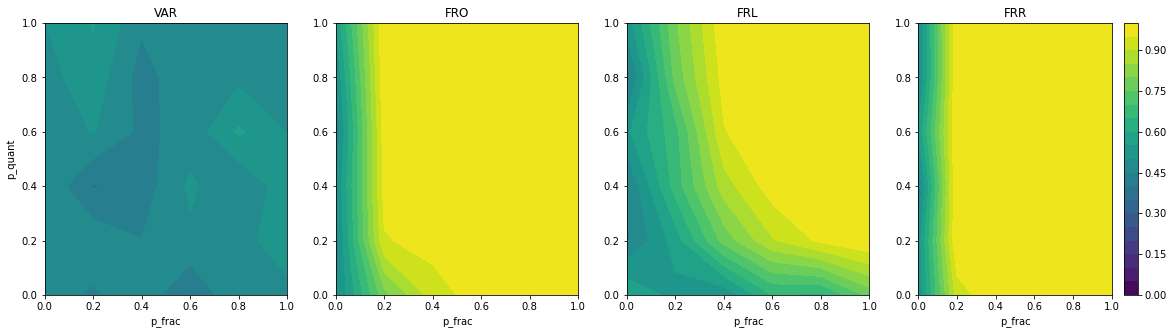

Algorithm type = dens, Dataset = 1
2021-04-20_15-45-19_pfq_all.txt pf


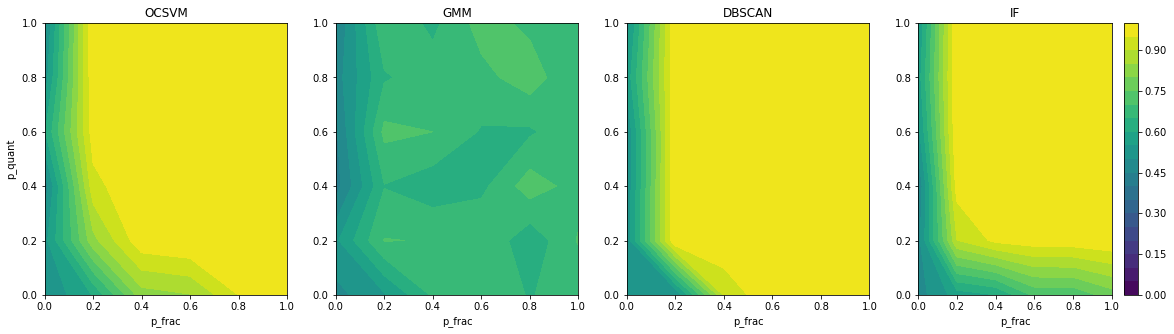

Algorithm type = dl, Dataset = 1
2021-04-20_15-45-19_pfq_all.txt pf


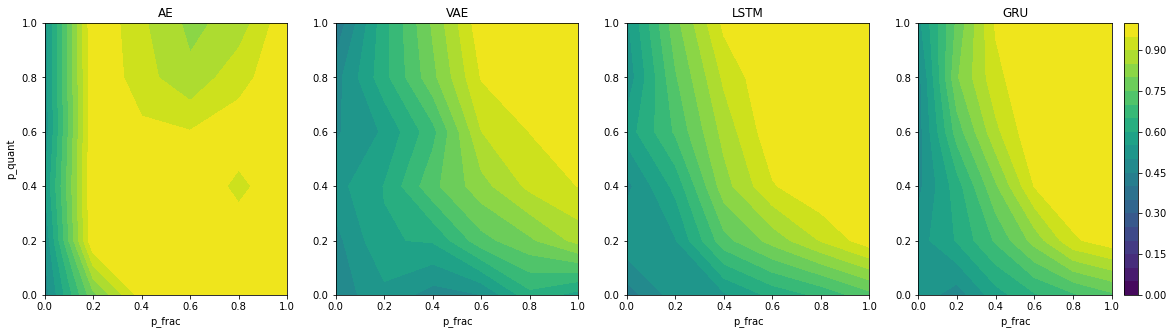

Algorithm type = mat, Dataset = 1
2021-04-20_15-45-19_pfq_all.txt pf


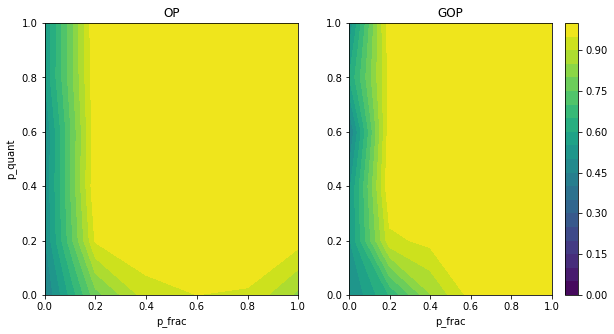

Algorithm type = reg, Dataset = 2
2021-04-20_15-45-19_pfq_all.txt pf


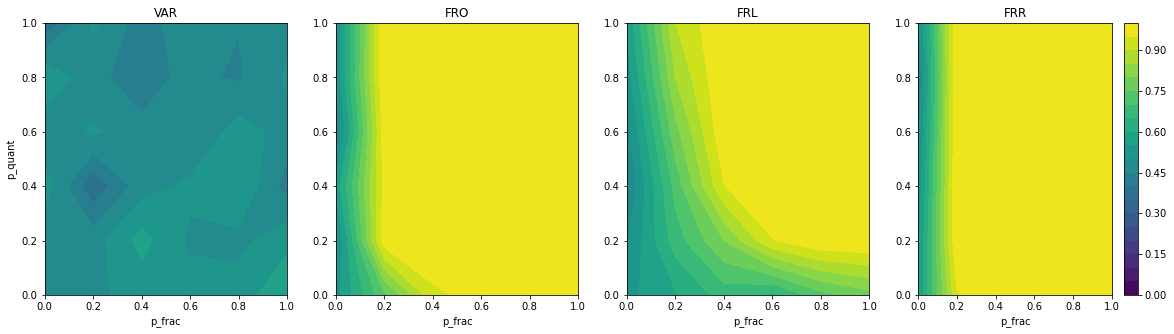

Algorithm type = dens, Dataset = 2
2021-04-20_15-45-19_pfq_all.txt pf


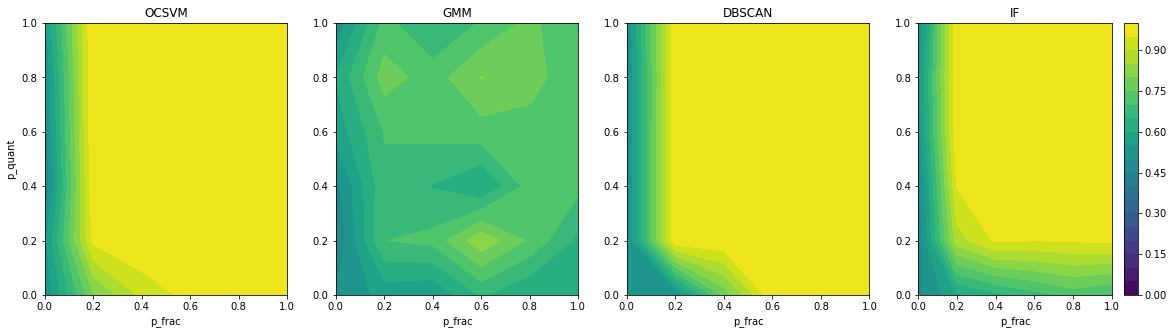

Algorithm type = dl, Dataset = 2
2021-04-20_15-45-19_pfq_all.txt pf


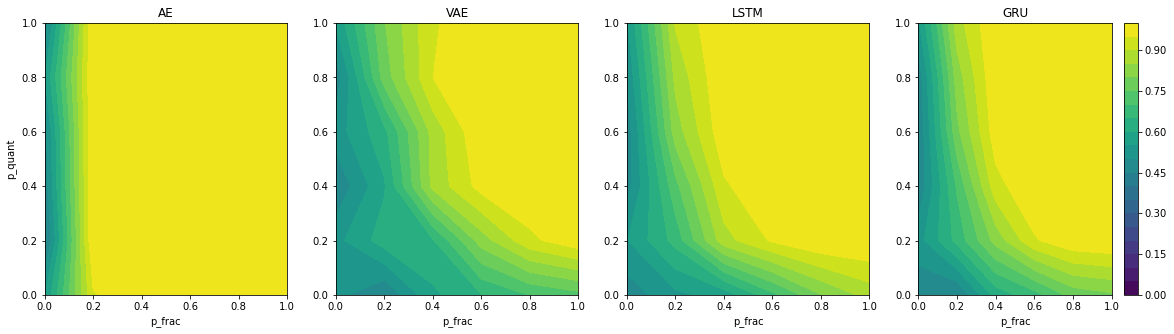

Algorithm type = mat, Dataset = 2
2021-04-20_15-45-19_pfq_all.txt pf


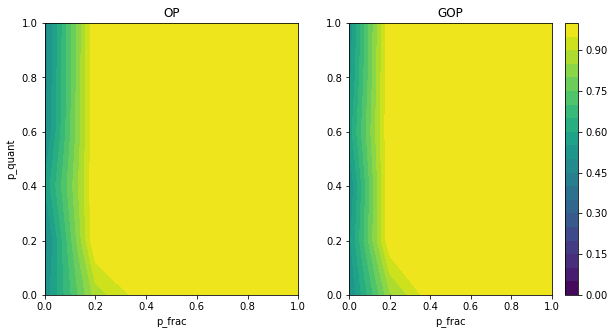

Algorithm type = reg, Dataset = 3
2021-04-20_15-45-19_pfq_all.txt pf


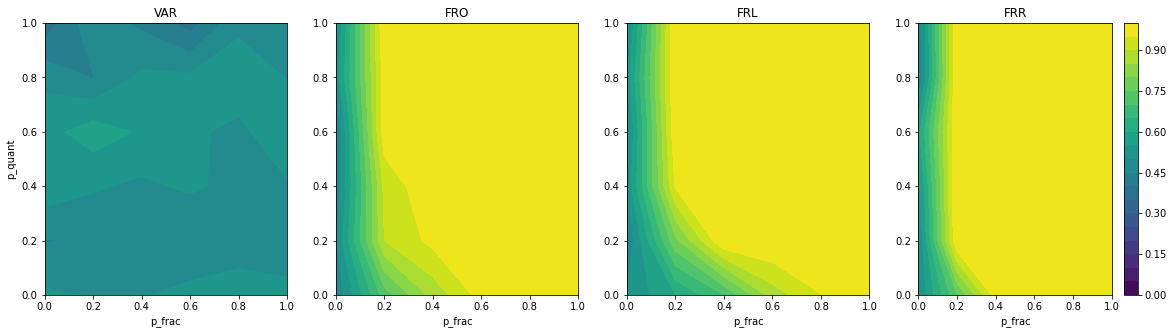

Algorithm type = dens, Dataset = 3
2021-04-20_15-45-19_pfq_all.txt pf


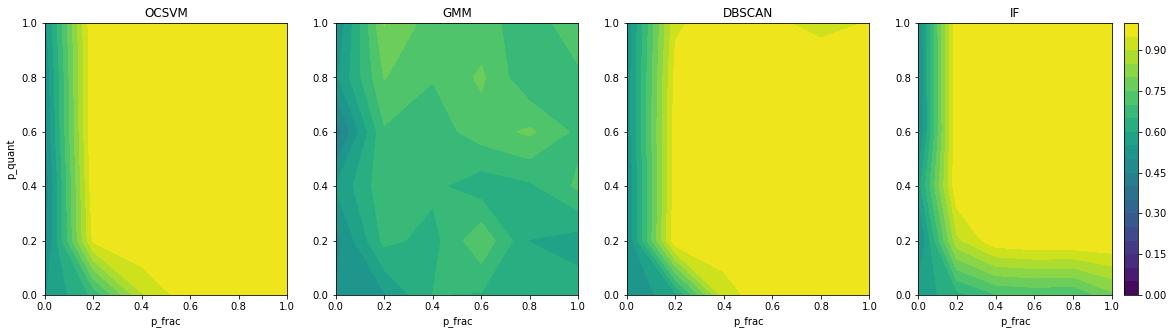

Algorithm type = dl, Dataset = 3
2021-04-20_15-45-19_pfq_all.txt pf


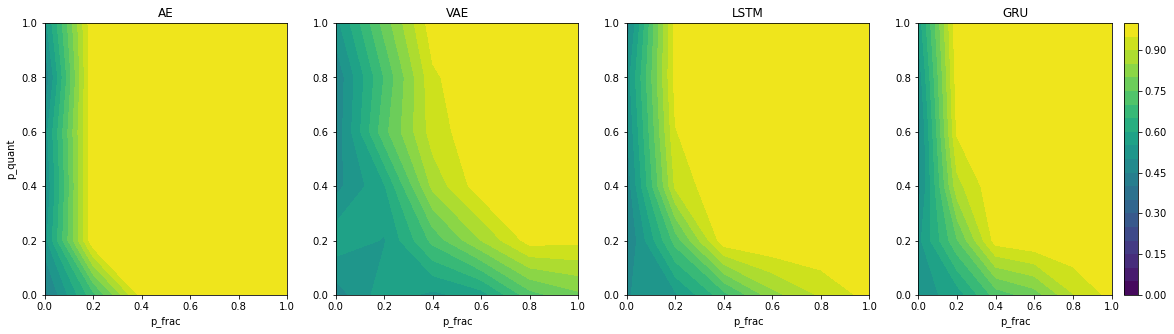

Algorithm type = mat, Dataset = 3
2021-04-20_15-45-19_pfq_all.txt pf


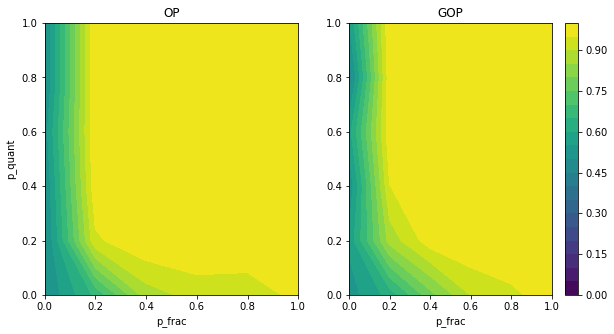

Algorithm type = reg, Dataset = 4
2021-04-20_15-45-19_pfq_all.txt pf


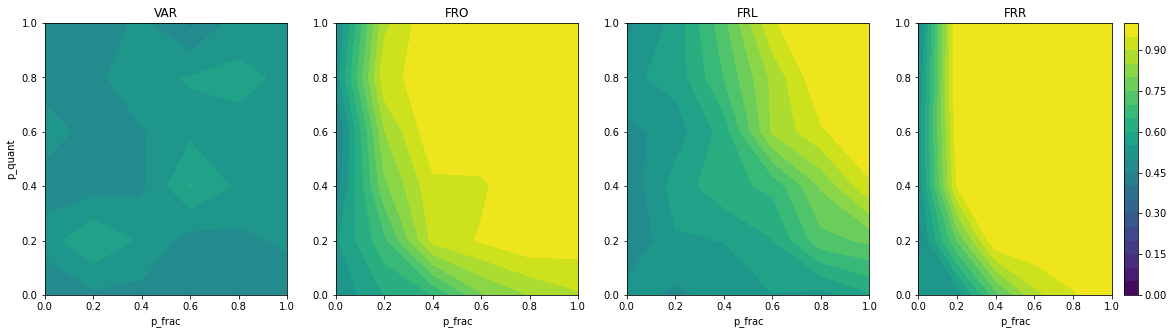

Algorithm type = dens, Dataset = 4
2021-04-20_15-45-19_pfq_all.txt pf


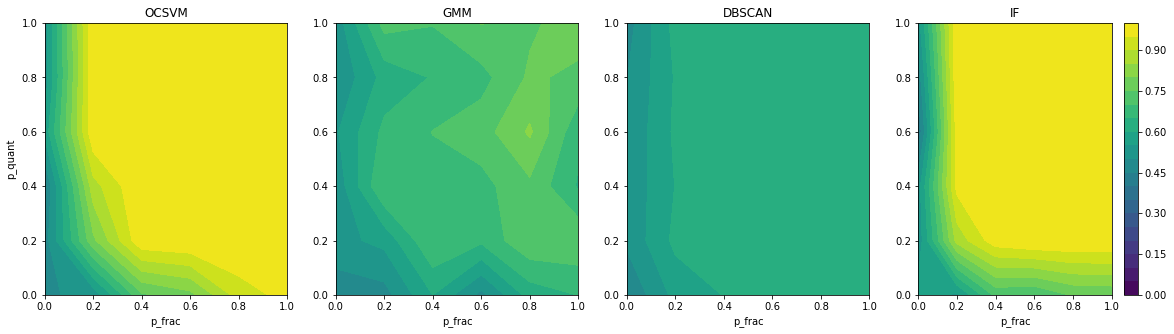

Algorithm type = dl, Dataset = 4
2021-04-20_15-45-19_pfq_all.txt pf


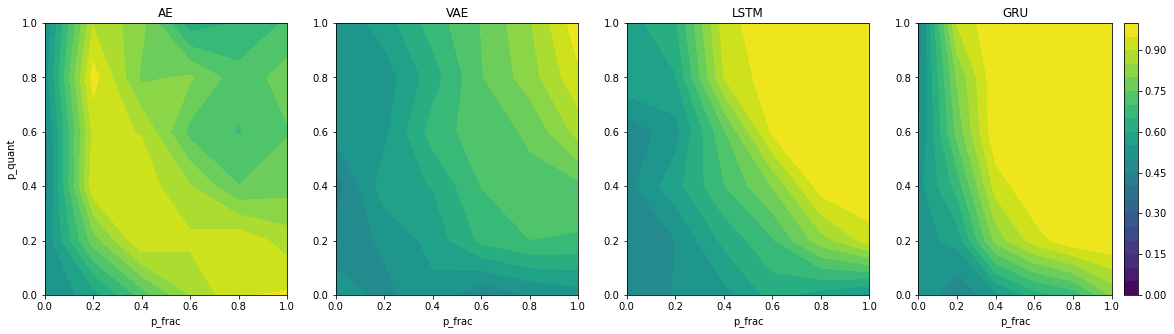

Algorithm type = mat, Dataset = 4
2021-04-20_15-45-19_pfq_all.txt pf


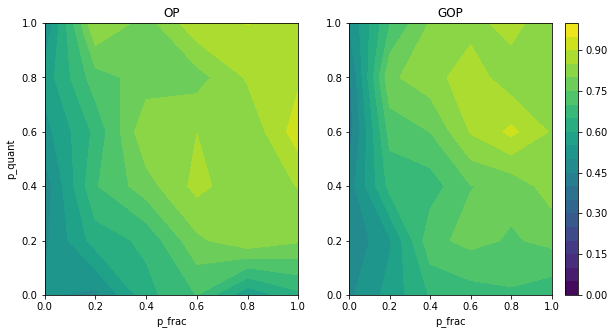

Algorithm type = reg, Dataset = 5
2021-04-20_15-45-19_pfq_all.txt pf


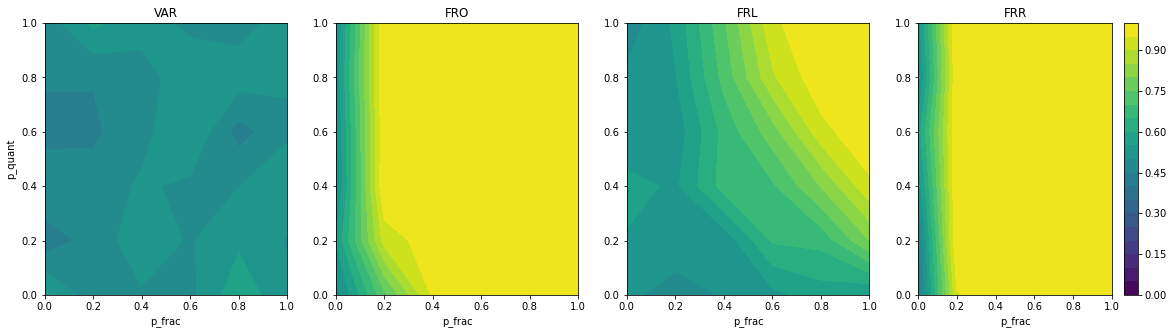

Algorithm type = dens, Dataset = 5
2021-04-20_15-45-19_pfq_all.txt pf


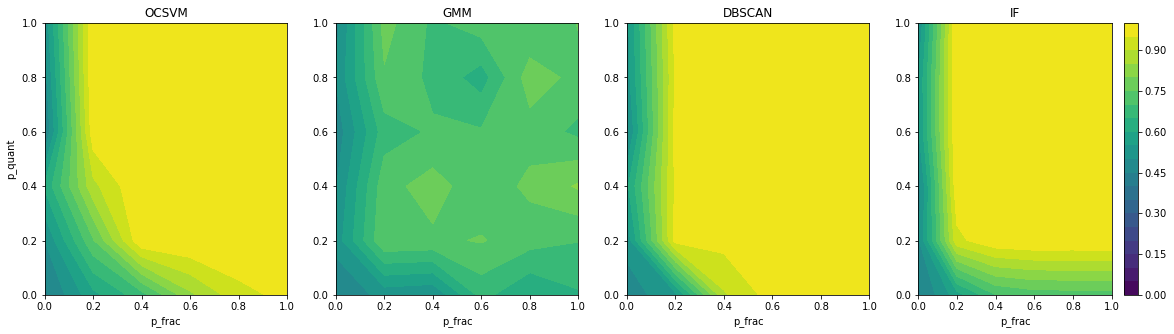

Algorithm type = dl, Dataset = 5
2021-04-20_15-45-19_pfq_all.txt pf


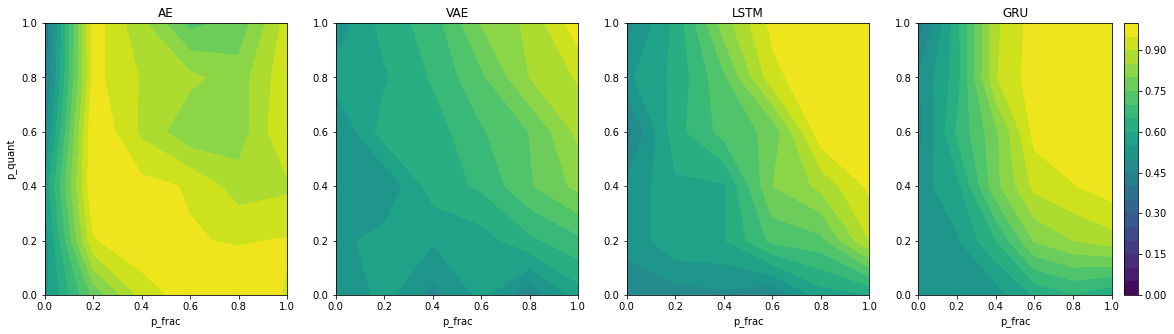

Algorithm type = mat, Dataset = 5
2021-04-20_15-45-19_pfq_all.txt pf


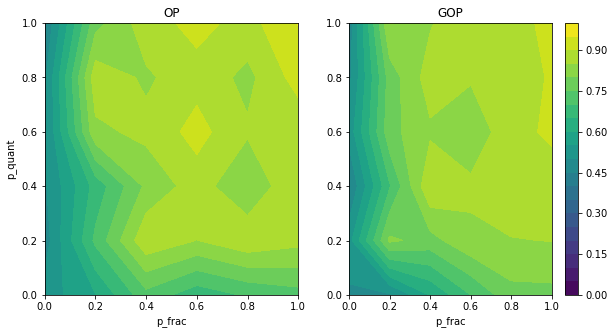

Algorithm type = reg, Dataset = 6
2021-04-20_15-45-19_pfq_all.txt pf


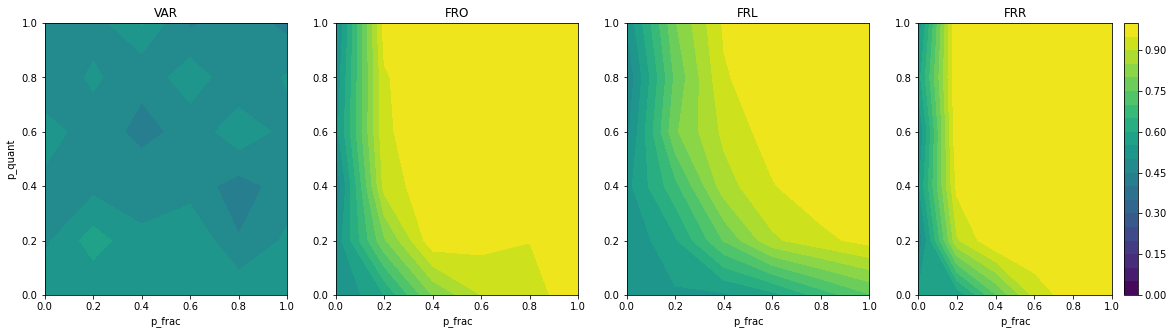

Algorithm type = dens, Dataset = 6
2021-04-20_15-45-19_pfq_all.txt pf


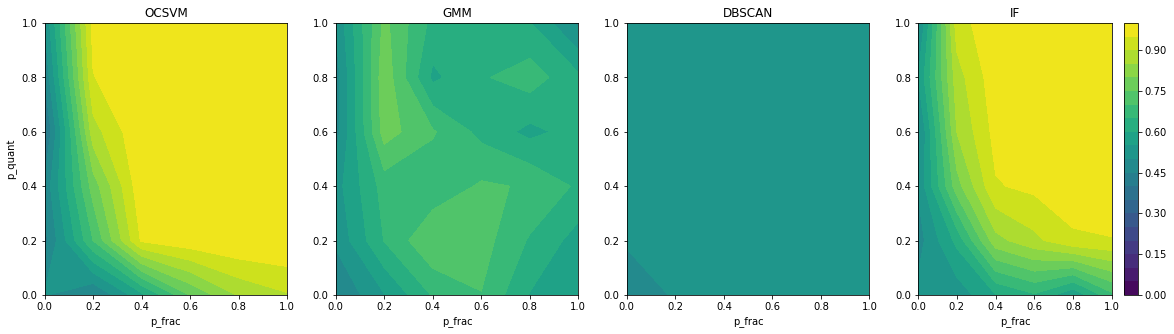

Algorithm type = dl, Dataset = 6
2021-04-20_15-45-19_pfq_all.txt pf


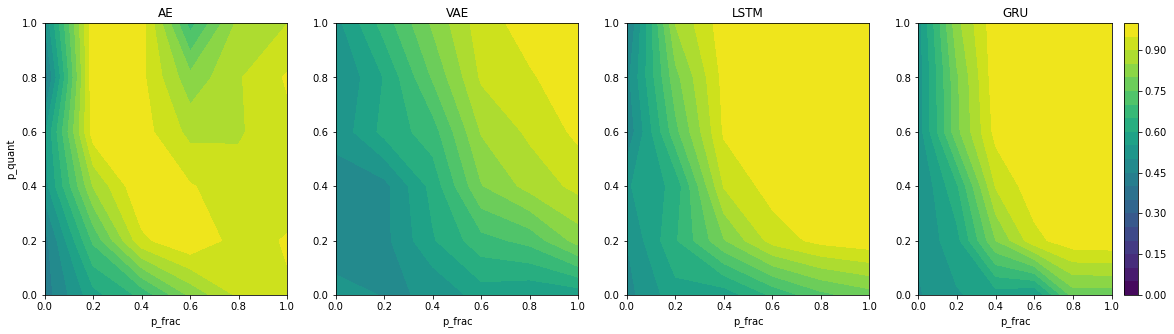

Algorithm type = mat, Dataset = 6
2021-04-20_15-45-19_pfq_all.txt pf


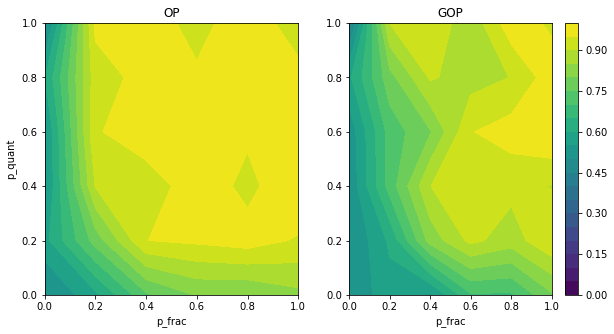

In [70]:
path = './results/'
ta=1
n_runs=10
score='auc'
for dataset in [1,2,3,4,5,6]:
    for algo_type in ['reg', 'dens', 'dl', 'mat']:  ## comment the rest of this back in for full experiment
        print(f'Algorithm type = {algo_type}, Dataset = {dataset}')
        get_contour_plot(path, timestamp,dataset, score)

To run the experiments again, run the box below. It may take a while..

In [71]:
timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
print(timestamp)
run_pfq_experiment_2(timestamp)

2023-08-15_15-50-37
VAR
p_frac=0.0, quant=0.0, runs=2, time= 0m 0s
p_frac=0.0, quant=0.2, runs=2, time= 0m 0s
p_frac=0.0, quant=0.4, runs=2, time= 0m 0s
p_frac=0.0, quant=0.6, runs=2, time= 0m 0s
p_frac=0.0, quant=0.8, runs=2, time= 0m 0s
p_frac=0.0, quant=1.0, runs=2, time= 0m 0s
p_frac=0.2, quant=0.0, runs=2, time= 0m 0s
p_frac=0.2, quant=0.2, runs=2, time= 0m 0s
p_frac=0.2, quant=0.4, runs=2, time= 0m 0s
p_frac=0.2, quant=0.6, runs=2, time= 0m 0s
p_frac=0.2, quant=0.8, runs=2, time= 0m 0s
p_frac=0.2, quant=1.0, runs=2, time= 0m 0s
p_frac=0.4, quant=0.0, runs=2, time= 0m 0s
p_frac=0.4, quant=0.2, runs=2, time= 0m 0s
p_frac=0.4, quant=0.4, runs=2, time= 0m 0s
p_frac=0.4, quant=0.6, runs=2, time= 0m 0s
p_frac=0.4, quant=0.8, runs=2, time= 0m 0s
p_frac=0.4, quant=1.0, runs=2, time= 0m 0s
p_frac=0.6, quant=0.0, runs=2, time= 0m 0s
p_frac=0.6, quant=0.2, runs=2, time= 0m 0s
p_frac=0.6, quant=0.4, runs=2, time= 0m 0s
p_frac=0.6, quant=0.6, runs=2, time= 0m 0s
p_frac=0.6, quant=0.8, runs=2,

p_frac=0.0, quant=0.6, runs=2, time= 0m 0s
p_frac=0.0, quant=0.8, runs=2, time= 0m 0s
p_frac=0.0, quant=1.0, runs=2, time= 0m 0s
p_frac=0.2, quant=0.0, runs=2, time= 0m 0s
p_frac=0.2, quant=0.2, runs=2, time= 0m 0s
p_frac=0.2, quant=0.4, runs=2, time= 0m 0s
p_frac=0.2, quant=0.6, runs=2, time= 0m 0s
p_frac=0.2, quant=0.8, runs=2, time= 0m 0s
p_frac=0.2, quant=1.0, runs=2, time= 0m 0s
p_frac=0.4, quant=0.0, runs=2, time= 0m 0s
p_frac=0.4, quant=0.2, runs=2, time= 0m 0s
p_frac=0.4, quant=0.4, runs=2, time= 0m 0s
p_frac=0.4, quant=0.6, runs=2, time= 0m 0s
p_frac=0.4, quant=0.8, runs=2, time= 0m 0s
p_frac=0.4, quant=1.0, runs=2, time= 0m 0s
p_frac=0.6, quant=0.0, runs=2, time= 0m 0s
p_frac=0.6, quant=0.2, runs=2, time= 0m 0s
p_frac=0.6, quant=0.4, runs=2, time= 0m 0s
p_frac=0.6, quant=0.6, runs=2, time= 0m 0s
p_frac=0.6, quant=0.8, runs=2, time= 0m 0s
p_frac=0.6, quant=1.0, runs=2, time= 0m 0s
p_frac=0.8, quant=0.0, runs=2, time= 0m 0s
p_frac=0.8, quant=0.2, runs=2, time= 0m 0s
p_frac=0.8,

TypeError: get_contour_plot() takes from 4 to 5 positional arguments but 9 were given

In [ ]:

def test(timestamp):

    algo_lst = ['VAR', 'FRO','AE', 'VAE', 'LSTM', 'GRU', 'OP', 'GOP']

    r = 20
    p_frac = 0.3
    p_quant = 0.3
    n_runs = 10
    gamma = 0.05
    timeout = 120
    noise=.1
    ta_lst = [1,2,3,4,5,6]
    p_lst = [1, 2, 3, 4, 5, 6]
    n_lst = [1, 2, 3, 4]
    atd = None

    ## for testing - comment out to run full experiment. may take a while..
    ta_lst = [1,2]
    p_lst = [1, 2, 3, 4]
    n_lst = [1, 2, 3]
    algo_lst = ['VAR', 'FRL', 'AE', 'VAE']
    atd = {'reg':['VAR', 'FRL'], 'dl':['AE', 'VAE']}
    n_runs=2
    ## end of testing section

    metric_lst = [auc, fps]
    for ta in ta_lst:
        plot_each_algo_for_np(n_lst, p_lst, r, gamma, noise, ta, p_quant, p_frac,n_runs,
                                    algo_lst, metric_lst, timeout, timestamp)
    df, dfr = get_all_data_np(timestamp)
    for algo_type in ['reg', 'dl']:
        get_contour_plot(timestamp,ta, len(p_lst), len(n_lst),'np', algo_type, 'auc', df, n_runs, atd=atd)

    return
timestamp = datetime.datetime.fromtimestamp(time())
timestamp = timestamp.strftime('%Y-%m-%d_%H-%M-%S')
test(timestamp)

VAR
n=10, p=2, runs=2, time= 0m 0s
n=100, p=2, runs=2, time= 0m 0s
n=1000, p=2, runs=2, time= 0m 0s
redoing due to singular matrix err
n=10, p=4, runs=2, time= 0m 0s
n=100, p=4, runs=2, time= 0m 0s
n=1000, p=4, runs=2, time= 0m 0s
n=10, p=8, runs=2, time= 0m 0s
n=100, p=8, runs=2, time= 0m 0s
n=1000, p=8, runs=2, time= 0m 0s
n=10, p=16, runs=2, time= 0m 0s
n=100, p=16, runs=2, time= 0m 0s
n=1000, p=16, runs=2, time= 0m 0s
Algorithm VAR with ta 1 took 0m and 0s to run 24 times
FRL
n=10, p=2, runs=2, time= 0m 0s
n=100, p=2, runs=2, time= 0m 0s
n=1000, p=2, runs=2, time= 0m 0s
n=10, p=4, runs=2, time= 0m 0s
n=100, p=4, runs=2, time= 0m 0s
n=1000, p=4, runs=2, time= 0m 0s
n=10, p=8, runs=2, time= 0m 0s
n=100, p=8, runs=2, time= 0m 0s
n=1000, p=8, runs=2, time= 0m 0s
n=10, p=16, runs=2, time= 0m 0s
n=100, p=16, runs=2, time= 0m 0s
n=1000, p=16, runs=2, time= 0m 0s
Algorithm FRL with ta 1 took 0m and 1s to run 24 times
AE
n=10, p=2, runs=2, time= 0m 0s
n=100, p=2, runs=2, time= 0m 1s
n=1000,